### A sample workflow for PyTorch:

Let's explore a sample end-to-end PyTorch workflow.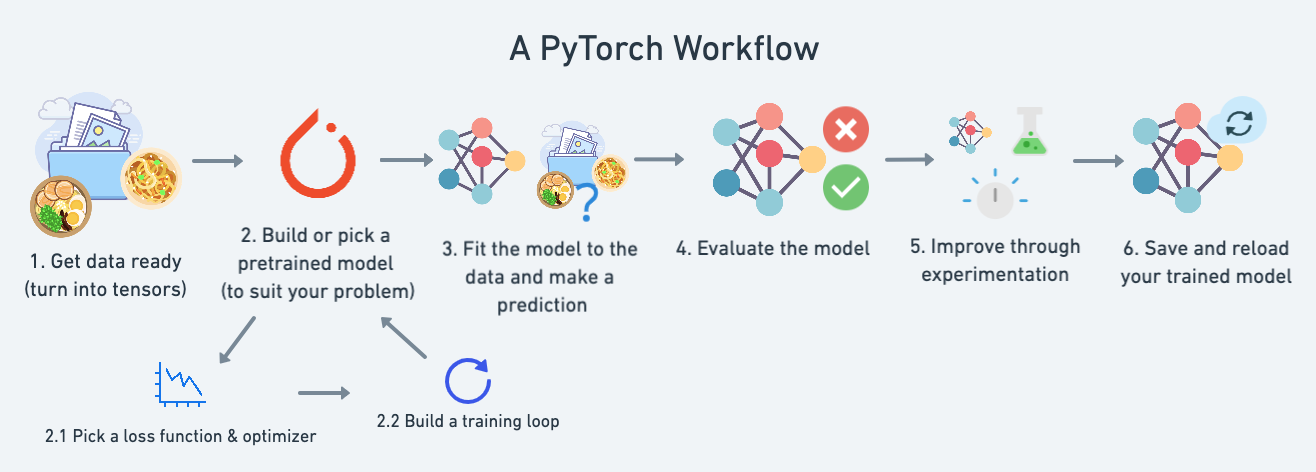

1. Get data ready (turn the data into tensors)
2. Build or pick a pretrained model (depending on the problem)
   1. Pick a loss function and optimizer
   2. Build a training loop
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload the trained model

In [1]:
what_were_covering = {1: "data (prepare and load)",
                      2: "build model",
                      3: "fit the model to the data (train)",
                      4: "make predictions and evaluate a model (inference)",
                      5: "save and load the model",
                      6: "put it all together"}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch building blocks for building neural networks
from matplotlib import pyplot as plt
import numpy as np

### Data (preparing and loading)

In ML, data can be almost anything:
* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text (Natural language etc.)

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some known data using the linear regression model.

We'll use a linear regression model to make a straight line with known **parameters**.



In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [4]:
# Train test split
train_split = int(0.8 * len(X))
train_split

40

In [5]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

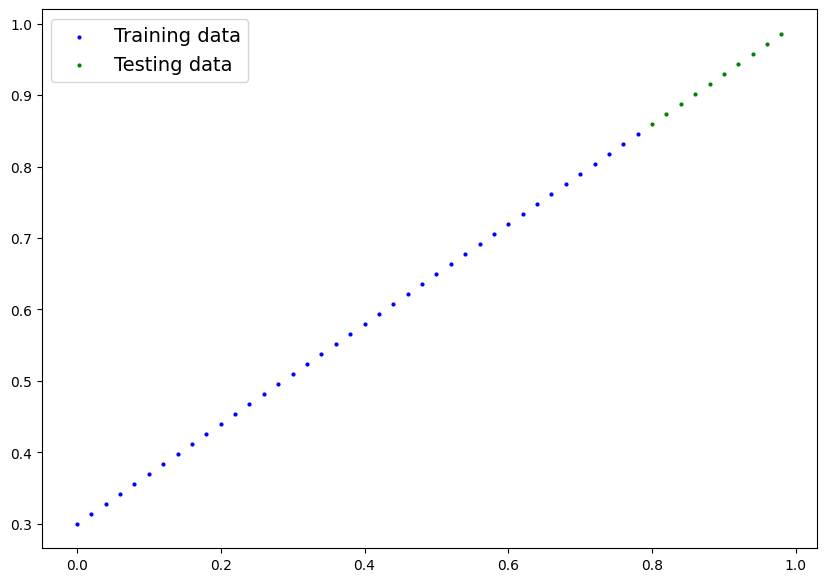

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  plt.legend(prop={"size":14})

plot_predictions()

In [7]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,requires_grad=True, dtype=torch.float32))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weight * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should the model try to learn (often, a PyTorch layer will set these for us)
* torch.nn.Module - the base class for all neural network modules, if we inherit from it then the `forward()` method should be overwritten
* torch.optim - this is where the PyTorch optimizers live, they will help with gradient descent
* `def forward()` - all nn.Module subclasses require forward to be overwritten, this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now that we have created a model, let's take a look inside

We can check the model parameters using `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference mode()`

To check the predictive power of the model, we can see how well it predicts y_test, given the inputs of X_test

When we pass data through the model, it will run it through the `forward()` method

In [10]:
# Make predictions with the model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

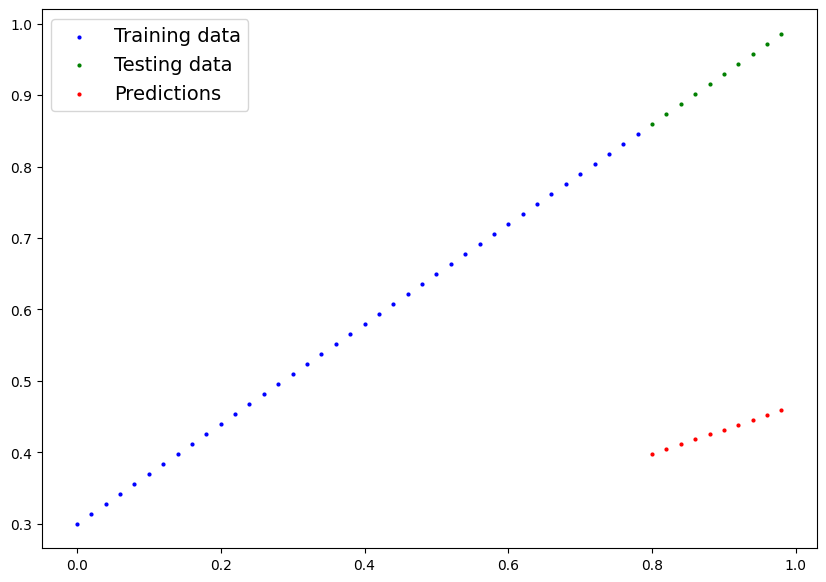

In [11]:
plot_predictions(predictions=y_preds)

### Training the model

The whole idea of training is for the model to move from some unknown parameters (these may be random) to some known parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure the performance of a model is to use a loss function.

* Note: loss functions may also be called a cost function or a criterion

Things we need to train:

* **Loss function**: A function to measure how far the model's predictions are compared to the ideal outputs.
* **Optimizer**: Takes into account the loss of the model and adjusts the model's parameters (e.g. weight and bias) to improve the loss function.

And specifically for PyTorch, we need:

* A training loop
* A testing loop

In [12]:
# Setup a loss function
loss_fn = nn.L1Loss() # This is the L1 or the MAE (Mean absolute error) loss function

# Setup an optimizer (Stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.001)

### Build a training loop and a testing loop in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (move the data through the model's forward function(s)) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust the model's parameteres to try to improve (lower) the loss (**gradient descent**)


In [13]:
# An epoch is one loop through the data (this is a hyperparemeter)
epochs = 2000

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):

  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration of the loop


  ### Testing
  model_0.eval() # turns off different settings in a model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking and a couple more things

    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 50 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

  # 3.



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weight', tensor([0.3371])), ('bias', tensor([0.1298]))])
Epoch: 50 | Loss: 0.2552763819694519 | Test loss: 0.4258342385292053
OrderedDict([('weight', tensor([0.3566])), ('bias', tensor([0.1798]))])
Epoch: 100 | Loss: 0.19767141342163086 | Test loss: 0.35847947001457214
OrderedDict([('weight', tensor([0.3761])), ('bias', tensor([0.2298]))])
Epoch: 150 | Loss: 0.14006686210632324 | Test loss: 0.2911251187324524
OrderedDict([('weight', tensor([0.3956])), ('bias', tensor([0.2798]))])
Epoch: 200 | Loss: 0.08973254263401031 | Test loss: 0.22795839607715607
OrderedDict([('weight', tensor([0.4150])), ('bias', tensor([0.3257]))])
Epoch: 250 | Loss: 0.06476505100727081 | Test loss: 0.18208928406238556
OrderedDict([('weight', tensor([0.4330])), ('bias', tensor([0.3556]))])
Epoch: 300 | Loss: 0.05357731133699417 | Test loss: 0.15086300671100616
OrderedDict([('weight', tensor([0.4485])), ('bias', tensor([0.3730]))])

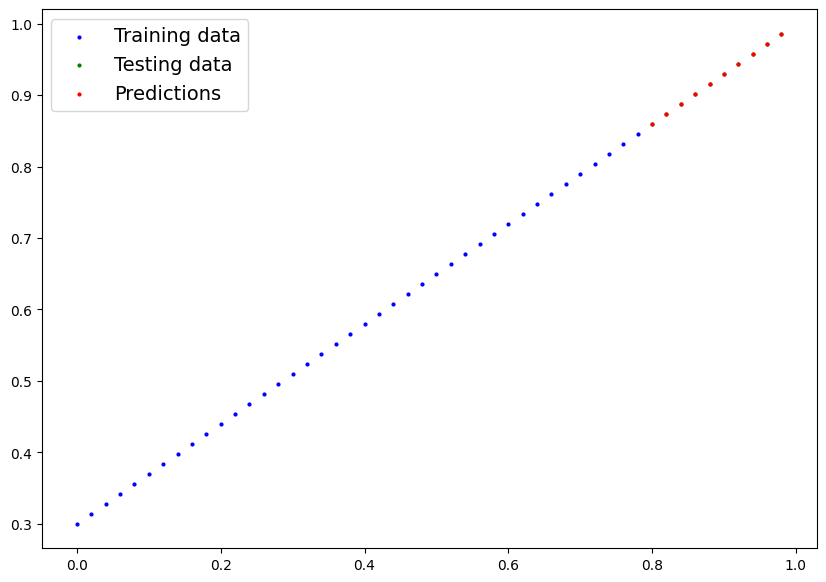

In [14]:
with torch.inference_mode():
  y_preds = model_0(X_test)
plot_predictions(predictions=y_preds)

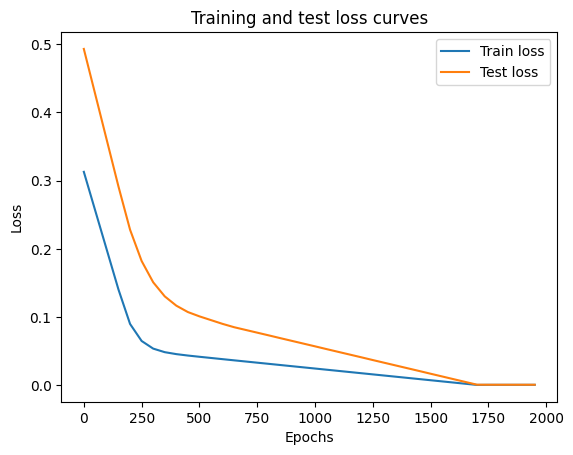

In [15]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving/Loading a model in PyTorch

There are 3 main methods for saving and loading model in PyTorch.

1. `torch.save()` - allows to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows to load a PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary





In [18]:
# Save the model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [20]:
# Initialize new model
model_0_loaded = LinearRegressionModel()

# Load the dict satate
model_0_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_0_loaded.state_dict()

OrderedDict([('weight', tensor([0.6994])), ('bias', tensor([0.2998]))])